# Import packages

In [1]:
# Reading/Writing Data
import os
import glob
import numpy as np
import math 

# Pytorch
import torch 
from torch.utils.data import DataLoader

# Self-Defined Package
from SMAPDataset import SMAPDataset
from DNNTEST import DNNTEST
from SDLoss import physics_loss
from Preprocessing import random_spatial_sequence, collate_fn

# Some Utility Functions

In [2]:
def same_seed(seed): 
    '''Fixes random number generator seeds for reproducibility.'''
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

# Configurations
`config` contains hyper-parameters for training and the path to save your model.

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
config = {
    'seed': 123456789,      # Your seed number, you can pick your lucky number. :)
    'test_ratio': 1,
    'test_batch_size': 1,
    'root': 'D:\\1GRADUATED\\paper\\downscaling_data\\Soil_moisture_downscale_czt\\DATASET\\'
}

# Dataloader
Read data from files and set up training, validation, and testing sets.

In [4]:
# # Set seed for reproducibility
same_seed(config['seed'])

##### 考虑到需要获取空间上均匀分布的站点数据，所以在每帧中随即挑选站点作为训练集，其余的作为验证集和测试集。因此使用一个字典来保存每天被筛选出来的站点list

In [5]:
test_sequence = {}
s2s_dir = config['root'] + 'LABEL\\SMAPID2INSITUID'
subdir_list = sorted(os.listdir(s2s_dir))

# 遍历指定路径下的所有子目录
for subdir in subdir_list:
    subdir_path = os.path.join(s2s_dir, subdir)
    if os.path.isdir(subdir_path):
        # 如果子目录是目录而不是文件，则将子目录加入字典
        full_spatial_sequence_smap = sorted([int(f.split('.')[0]) for f in os.listdir(subdir_path) if f.endswith('.npy')]) # !!!! read out of order
        print(len(full_spatial_sequence_smap), 'of Full Spatial Sequence for', subdir, ':')
        print(full_spatial_sequence_smap)
        
        test_sequence[subdir] = full_spatial_sequence_smap

10 of Full Spatial Sequence for 2015104 :
[9, 15, 17, 18, 20, 26, 29, 31, 40, 43]
6 of Full Spatial Sequence for 2015106 :
[15, 16, 20, 26, 27, 29]
4 of Full Spatial Sequence for 2015114 :
[9, 33, 44, 51]
14 of Full Spatial Sequence for 2015115 :
[15, 16, 17, 18, 20, 26, 29, 31, 32, 33, 40, 41, 43, 44]
5 of Full Spatial Sequence for 2015117 :
[16, 31, 32, 33, 44]
2 of Full Spatial Sequence for 2015130 :
[16, 29]
19 of Full Spatial Sequence for 2015131 :
[9, 10, 15, 16, 17, 18, 20, 26, 27, 29, 31, 32, 33, 40, 41, 43, 44, 45, 51]
1 of Full Spatial Sequence for 2015136 :
[15]
2 of Full Spatial Sequence for 2015138 :
[26, 27]
11 of Full Spatial Sequence for 2015149 :
[15, 16, 17, 20, 26, 27, 29, 31, 32, 40, 41]
1 of Full Spatial Sequence for 2015160 :
[17]
7 of Full Spatial Sequence for 2015162 :
[15, 16, 17, 26, 27, 31, 40]
12 of Full Spatial Sequence for 2015165 :
[9, 10, 16, 17, 18, 20, 31, 32, 33, 40, 44, 45]
10 of Full Spatial Sequence for 2015171 :
[20, 29, 31, 32, 33, 41, 43, 44, 45

In [6]:
print(test_sequence)

{'2015104': [9, 15, 17, 18, 20, 26, 29, 31, 40, 43], '2015106': [15, 16, 20, 26, 27, 29], '2015114': [9, 33, 44, 51], '2015115': [15, 16, 17, 18, 20, 26, 29, 31, 32, 33, 40, 41, 43, 44], '2015117': [16, 31, 32, 33, 44], '2015130': [16, 29], '2015131': [9, 10, 15, 16, 17, 18, 20, 26, 27, 29, 31, 32, 33, 40, 41, 43, 44, 45, 51], '2015136': [15], '2015138': [26, 27], '2015149': [15, 16, 17, 20, 26, 27, 29, 31, 32, 40, 41], '2015160': [17], '2015162': [15, 16, 17, 26, 27, 31, 40], '2015165': [9, 10, 16, 17, 18, 20, 31, 32, 33, 40, 44, 45], '2015171': [20, 29, 31, 32, 33, 41, 43, 44, 45, 51], '2015176': [9, 10, 15, 17, 18, 20, 26, 31, 32, 33, 40, 41, 43, 44], '2015186': [9, 10, 15, 16, 17, 18, 20, 26, 27, 29, 31, 32, 33, 40, 41, 43, 44, 51], '2015187': [9, 10, 15, 16, 17, 18, 20, 26, 27, 29, 43, 44, 45, 51], '2015194': [9, 10, 26], '2015195': [10, 29, 31, 40], '2015200': [15, 16, 27, 29, 40, 43], '2015202': [9], '2015203': [16, 17, 26, 33], '2015205': [10, 18, 27, 43, 44, 45, 51], '2015208'

In [7]:
# Initialize the dataset
test_dataset = SMAPDataset(config['root'], test_sequence)

# Pytorch data loader loads pytorch dataset into batches.
test_loader = DataLoader(test_dataset, batch_size=config['test_batch_size'], shuffle=False, pin_memory=True, collate_fn=collate_fn)

***************************Load data path******************************
_______________________________2015104_______________________________
_____________________________smap cell: 9_____________________________
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\INPUT\SMAP\2015104\9.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\INPUT\TEXTURE\9.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\LABEL\SM\2015104\55.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\LABEL\ATI\2015104\55.npy
_____________________________smap cell: 15_____________________________
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\INPUT\SMAP\2015104\15.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\INPUT\TEXTURE\15.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\LABEL\SM\2015104\4.npy
D:\1GRADUATED\paper\downscaling_data\Soi

D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\INPUT\TEXTURE\20.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\LABEL\SM\2015221\27.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\LABEL\ATI\2015221\27.npy
_____________________________smap cell: 41_____________________________
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\INPUT\SMAP\2015221\41.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\INPUT\TEXTURE\41.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\LABEL\SM\2015221\6.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\LABEL\ATI\2015221\6.npy
_______________________________2015226_______________________________
_____________________________smap cell: 9_____________________________
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\INPUT\SMAP\2015226\9.npy
D:\1GRADUATED\

D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\INPUT\SMAP\2015226\43.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\INPUT\TEXTURE\43.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\LABEL\SM\2015226\53.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\LABEL\ATI\2015226\53.npy
_____________________________smap cell: 44_____________________________
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\INPUT\SMAP\2015226\44.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\INPUT\TEXTURE\44.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\LABEL\SM\2015226\11.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\LABEL\ATI\2015226\11.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\LABEL\SM\2015226\42.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_down

D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\LABEL\ATI\2015235\6.npy
_____________________________smap cell: 43_____________________________
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\INPUT\SMAP\2015235\43.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\INPUT\TEXTURE\43.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\LABEL\SM\2015235\53.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\LABEL\ATI\2015235\53.npy
_____________________________smap cell: 44_____________________________
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\INPUT\SMAP\2015235\44.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\INPUT\TEXTURE\44.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\LABEL\SM\2015235\11.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\LABEL\AT

In [8]:
print(test_dataset.__len__())

409


# Data visualization

In [9]:
import matplotlib.pyplot as plt

In [10]:
def display_data_spatial_distribution(full_smapid_sequence, dict_sequence, data_name, root, seed):
    # 创建一个空数组
    bg_scale = -10
    z_scale = -5
    verified_mat = np.ones((7, 13))
    verified_mat = verified_mat * bg_scale
    verified_mat[0][2:7] = z_scale
    verified_mat[1][0:8] = z_scale
    verified_mat[2][0:10] = z_scale
    verified_mat[3][0:12] = z_scale
    verified_mat[4][2:13] = z_scale
    verified_mat[5][6:13] = z_scale
    verified_mat[6][7:12] = z_scale
    row_i = np.where(verified_mat!=bg_scale)[0]
    col_j = np.where(verified_mat!=bg_scale)[1]
    
    # 确定cell数据量的大小
    for smapid in full_smapid_sequence:
        y = [key for key, value in dict_sequence.items() if smapid in value]
        verified_mat[row_i[smapid]][col_j[smapid]] = len(y)

    plt.figure(figsize=(13, 7))
    plt.imshow(verified_mat, alpha=0.8, extent=[0, 13, 0, 7], vmin=-10, vmax=20, cmap='coolwarm')
    
    # 设置图形标题
    plt.title('Number of {} Data in Each Cell'.format(data_name))
    plt.xticks(range(14))
    plt.grid(True)
    plt.colorbar()
    
#     # 显示图形
#     plt.savefig(root + 'OUTPUT\\IMAGE\\DATAVISUALIZE\\' + str(seed) + '\\' + data_name + 'DataSpatialDistribution.png', dpi=600, transparent=False)    
#     plt.show()


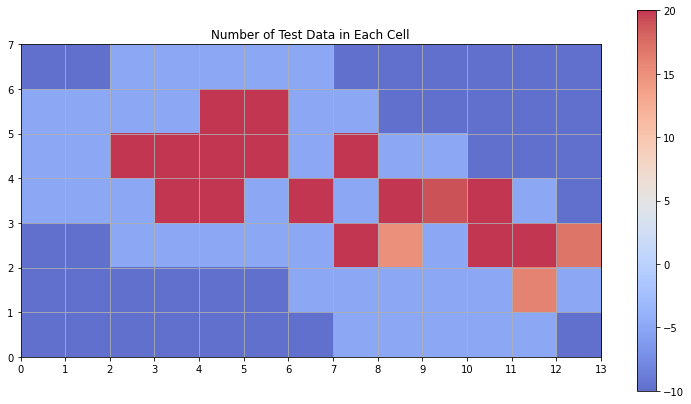

In [11]:
test_full_smapid_sequence = test_dataset.get_full_smapid_sequence()
display_data_spatial_distribution(test_full_smapid_sequence, test_sequence, 'Test', config['root'], config['seed'])

In [12]:
def display_data_temporal_distribution(full_smapid_sequence, dict_sequence, data_name, root, seed):
    # 绘制散点图
    plt.figure(figsize=(13, 7))

    X = range(len(full_smapid_sequence))
    for i, smapid in enumerate(full_smapid_sequence):
        y = [int(key.split('2015')[1]) for key, value in dict_sequence.items() if smapid in value]
        x = [i] * len(y)  # 重复 X 坐标以便绘制多个散点
        plt.scatter(x, y)

    # 设置图形标题和坐标轴标签
    plt.title(data_name + ' Time Sequence Distribution for Each SMAP Cell')
    plt.xlabel("SMAPID")
    plt.ylabel("Day")
    plt.xticks(X, list(full_smapid_sequence))
    plt.yticks(np.arange(90, 360, 20))

#     # 显示图形
#     plt.savefig(root + 'OUTPUT\\IMAGE\\DATAVISUALIZE\\' + str(seed) + '\\' + data_name + 'DataTemporalDistribution.png', dpi=600, transparent=False)    
#     plt.show()

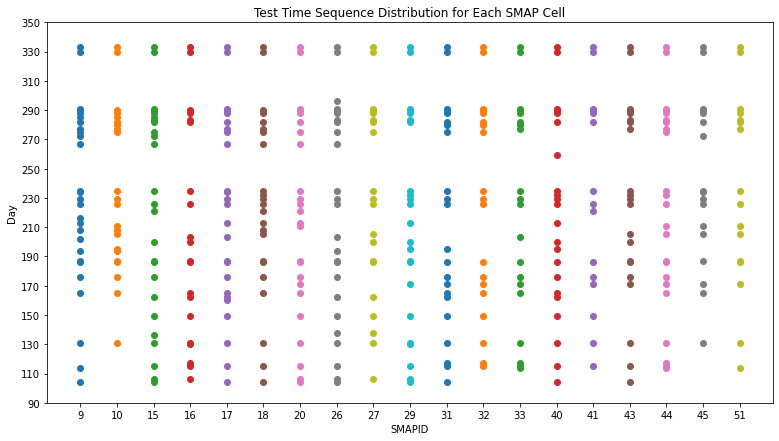

In [13]:
test_full_smapid_sequence = test_dataset.get_full_smapid_sequence()
display_data_temporal_distribution(test_full_smapid_sequence, test_sequence, 'Test', config['root'], config['seed'])

## Testing

In [14]:
def tester(test_loader, model, config, device):
    criterion = physics_loss # Define your loss function, do not modify this.
    model.eval() # Set your model to evaluation mode.
    loss_record = []
    for data_pkg in test_loader:
        x = data_pkg['processed_data']
        print(x.shape)
#         x, y = x.to(device), y.to(device)   # Move your data to device. 
        with torch.no_grad():
            pred = model(x)
            print(pred)
            loss = criterion(pred, data_pkg['label_data'], config['test_batch_size'])
        loss_record.append(loss.item())
    mean_test_loss = sum(loss_record)/len(loss_record)
    print(len(loss_record))
    print(mean_test_loss)
#     print(loss_record)  
    return loss_record

In [15]:
param_path = os.path.join(config['root'],'OUTPUT\\MODELS\\output.ckpt' )
model = DNNTEST(input_dim=test_dataset.get_input_shape(0)[0]).to(device)
model.load_state_dict(torch.load(param_path))
loss_record = tester(test_loader, model, config, device) 

torch.Size([1, 1937])
tensor([0.0009])
torch.Size([1, 1937])
tensor([0.0009])
torch.Size([1, 1937])
tensor([0.0009])
torch.Size([1, 1937])
tensor([0.0009])
torch.Size([1, 1937])
tensor([0.0009])
torch.Size([1, 1937])
tensor([0.0009])
torch.Size([1, 1937])
tensor([0.0009])
torch.Size([1, 1937])
tensor([0.0009])
torch.Size([1, 1937])
tensor([0.0009])
torch.Size([1, 1937])
tensor([0.0009])
torch.Size([1, 1937])
tensor([0.0009])
torch.Size([1, 1937])
tensor([0.0009])
torch.Size([1, 1937])
tensor([0.0009])
torch.Size([1, 1937])
tensor([0.0009])
torch.Size([1, 1937])
tensor([0.0009])
torch.Size([1, 1937])
tensor([0.0009])
torch.Size([1, 1937])
tensor([0.0009])
torch.Size([1, 1937])
tensor([0.0009])
torch.Size([1, 1937])
tensor([0.0009])
torch.Size([1, 1937])
tensor([0.0009])
torch.Size([1, 1937])
tensor([0.0009])
torch.Size([1, 1937])
tensor([0.0009])
torch.Size([1, 1937])
tensor([0.0009])
torch.Size([1, 1937])
tensor([0.0009])
torch.Size([1, 1937])
tensor([0.0009])
torch.Size([1, 1937])
ten

tensor([0.0009])
torch.Size([1, 1937])
tensor([0.0009])
torch.Size([1, 1937])
tensor([0.0009])
torch.Size([1, 1937])
tensor([0.0009])
torch.Size([1, 1937])
tensor([0.0009])
torch.Size([1, 1937])
tensor([0.0009])
torch.Size([1, 1937])
tensor([0.0009])
torch.Size([1, 1937])
tensor([0.0009])
torch.Size([1, 1937])
tensor([0.0009])
torch.Size([1, 1937])
tensor([0.0009])
torch.Size([1, 1937])
tensor([0.0009])
torch.Size([1, 1937])
tensor([0.0009])
torch.Size([1, 1937])
tensor([0.0009])
torch.Size([1, 1937])
tensor([0.0009])
torch.Size([1, 1937])
tensor([0.0009])
torch.Size([1, 1937])
tensor([0.0009])
torch.Size([1, 1937])
tensor([0.0009])
torch.Size([1, 1937])
tensor([0.0009])
torch.Size([1, 1937])
tensor([0.0009])
torch.Size([1, 1937])
tensor([0.0009])
torch.Size([1, 1937])
tensor([0.0009])
torch.Size([1, 1937])
tensor([0.0009])
torch.Size([1, 1937])
tensor([0.0009])
torch.Size([1, 1937])
tensor([0.0009])
torch.Size([1, 1937])
tensor([0.0009])
torch.Size([1, 1937])
tensor([0.0009])
torch.Si

In [16]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

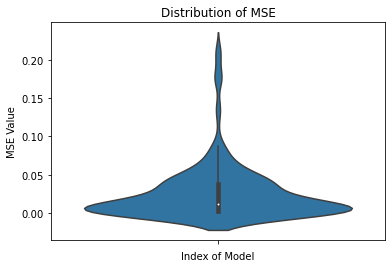

In [17]:
# 将数据转换为DataFrame格式
df = pd.DataFrame(loss_record, columns=['MSE'])

# 绘制小提琴图
sns.violinplot(y='MSE', data=df, scale='count')
# sns.barplot(y='MSE', data=df)
# 添加标题和标签
plt.title('Distribution of MSE')
plt.xlabel('Index of Model')
plt.ylabel('MSE Value')

# 显示图形
plt.savefig(config['root'] + 'OUTPUT\\IMAGE\\DATAVISUALIZE\\' + str(config['seed']) + '\\' + 'MSEDistribution.png', dpi=600, transparent=False)    
plt.show()